# cpDetect with clean up step
This notebook runs cpDetect on a list of synthetic trajectories generated in the synthetic data notebook. 
After the change points are found, you can run a cleanup (refinement) step to find change points that were missed the 
in the first iteration. (An illustration how the refinement step works is given in the cell above that step)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from cpdetect import cpDetector
import pandas as pd
from matplotlib.backends.backend_pdf import PdfPages
from tqdm import *
try:
    import cPickle as pickle
except:
    import pickle

In [2]:
# Load data and format for cpDetect
trajs = np.load('synthetic_trajs.np.npy')
trajs = trajs.tolist()

In [4]:
# Instantiate detector and run detect_cp()
detector = cpDetector(trajs, distribution='log_normal', log_odds_threshold=0)
detector.detect_cp()

16:06:16 INFO cpDetector: =======================================
16:06:16 INFO cpDetector: Running change point detector
16:06:16 INFO cpDetector: =======================================
16:06:16 INFO cpDetector:    input observations: 100 of length [6619, 3912, 5976, 1174, 6712, 6773, 4044, 8713, 6155, 6781, 2125, 2663, 9010, 6195, 669, 2460, 3790, 7660, 1790, 6342, 1423, 5108, 7384, 6459, 7274, 3801, 5875, 2472, 1448, 3741, 5409, 5364, 901, 2618, 4233, 4231, 7778, 1121, 2324, 3515, 3413, 4906, 6938, 1833, 3757, 4537, 4654, 4509, 5181, 1659, 4429, 4730, 9153, 4449, 5404, 6585, 6791, 1921, 11332, 2859, 6909, 5050, 7009, 1718, 1957, 4055, 4223, 1347, 5834, 9603, 4310, 9185, 5061, 8030, 7411, 3906, 5093, 4480, 833, 7866, 2140, 5581, 7256, 4862, 3163, 5466, 2773, 8814, 9310, 1719, 3242, 7678, 4153, 2009, 3403, 1817, 9301, 5068, 3920, 3609]
16:06:16 INFO cpDetector: Running cp detector on traj 0
16:06:16 INFO cpDetector: ---------------------------------
16:06:16 INFO cpDetector:     Foun

In [20]:
# Save results
true_ts = pickle.load(open('true_ts_new.pickle', 'rb'))
detector = pickle.load(open('refinement_detector.pickle', 'rb'))
step = pickle.load(open('step_synthetic_new.pickle', 'rb'))

In [5]:
# Compute confusion matrix
cm = np.zeros((2, 2))
tp = 0
fp = 0
fn = 0
for t in range(len(trajs)):
    true_positive = []
    false_negative = true_ts['traj_{}'.format(t)]
    false_positive = np.asarray(detector.change_points['traj_{}'.format(t)]['ts'])
    #n += len(false_positive)
    index_neg = []
    for i, t_ts in enumerate(false_negative):
        for j, p_ts in enumerate(false_positive):
            if t_ts-100 <= p_ts <= t_ts+100:
                true_positive.append(p_ts)
                index_neg.append(i)
                #index = np.where(false_negative==t_ts)
                #false_negative = np.delete(false_negative, index)
                #index = np.where(false_positive==p_ts)
                false_positive = np.delete(false_positive, j)
                break
    false_negative = np.delete(false_negative, index_neg)
    # sanity check
    assert(len(true_ts['traj_{}'.format(t)]) == (len(true_positive) + len(false_negative)))
    assert(len(np.asarray(detector.change_points['traj_{}'.format(t)]['ts'])) == 
           (len(true_positive) + len(false_positive)))
    tp += len(true_positive)
    fp += len(false_positive)
    fn += len(false_negative)
cm = np.array(([tp, fp], [fn, 0]))

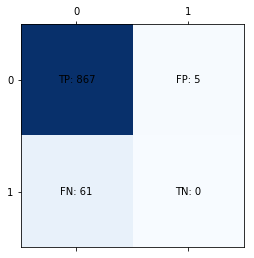

In [6]:
# Plot confusion matrix
key = [['TP', 'FN'], ['FP', 'TN']]
plt.matshow(cm, cmap='Blues')
for (j, k), label in np.ndenumerate(cm):
    l = key[k][j] + ': ' + str(int(label))
    plt.text(k,j,l,ha='center',va='center')

True Positive: 867

False Positive: 5

False Negative: 61

True Negative is set to 0. 

## Refinement step
cpDetect is a recursive algorithm. It keeps on finding splits until the probability for a split is below the chosen threshold. First it calculates the Bayes Factor of the entire trajectory coming from one underlying distribution vs. two distributions. If the Bayes Factor is above the threshold, it finds the maximum likelihood time point for the change point and splits the trajectory there. It then calculates the Bayes factor again for both splits and keeps doing that until it stops finding splits. 

Since the probabilities are calculated for all segments, regardless if a change point is found, cpDetect saves them in the `no_split` dictionary. Below is a plot of one such a segment. 

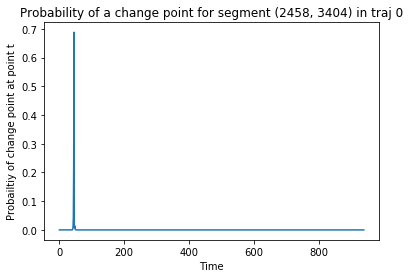

In [43]:
plt.plot(detector.no_split['traj_0']['prob_ts'][4])
plt.title('Probability of a change point for segment (2458, 3404) in traj 0')
plt.xlabel('Time')
plt.ylabel('Probailtiy of change point at point t')

This is what the corresponding trajectory looks like:

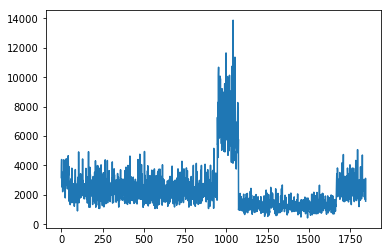

In [41]:
plt.plot(trajs[0][2458:4303])


While no split was found in this segment, there is a significant probability that a change occured somewhere around 90. What the refinement step does is split this segment at the maximum of this probabily, plus and minus the split window given. Then it recacluates the Bayse factor for those two segments. cpDetect sometimes misses fast transitions because the part of the trajectory that's from a different distribution is a very small part of the rest of the segment. When the trajectory is split in such a way where either the intensity doesn't come down again in the same segment, or where the intensity of a different state makes up a larger part of the segment, there's a higher probabiltiy of finding that transition. In addition, at this step the algorithm isn't recursive so a more aggresive threshold will pick up less fasle positives. 

You can choose the split window size (how many points after and before the max of P(t) to split the trajectory),
the reject window size (how big the window should be for a new change point to be considered a new change point),
and the threshold. 

In [23]:
# refinement

detector.refinement(threshold=-5, reject_window=20)

16:49:54 INFO cpDetector: Found a new change point in traj 0 at 87
16:49:54 INFO cpDetector: Found a new change point in traj 0 at 87
16:49:54 INFO cpDetector: Found a new change point in traj 0 at 2506
16:49:56 INFO cpDetector: Found a new change point in traj 6 at 2557
16:49:56 INFO cpDetector: Found a new change point in traj 6 at 2673
16:49:57 INFO cpDetector: Found a new change point in traj 8 at 2665
16:49:59 INFO cpDetector: Found a new change point in traj 14 at 621
16:50:00 INFO cpDetector: Found a new change point in traj 18 at 745
16:50:00 INFO cpDetector: Found a new change point in traj 20 at 925
16:50:00 INFO cpDetector: Found a new change point in traj 20 at 1326
16:50:01 INFO cpDetector: Found a new change point in traj 23 at 4589
16:50:03 INFO cpDetector: Found a new change point in traj 30 at 1174
16:50:03 INFO cpDetector: Found a new change point in traj 30 at 1222
16:50:04 INFO cpDetector: Found a new change point in traj 32 at 603
16:50:05 INFO cpDetector: Found a 

In [8]:
detector.regenerate_step_function()

/Users/sternc1/anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


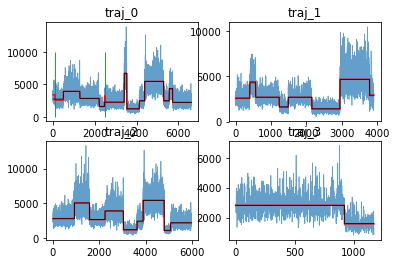

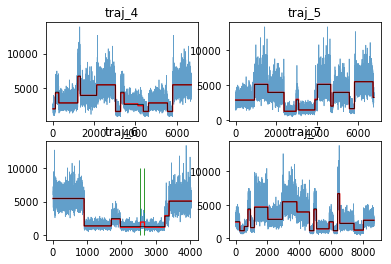

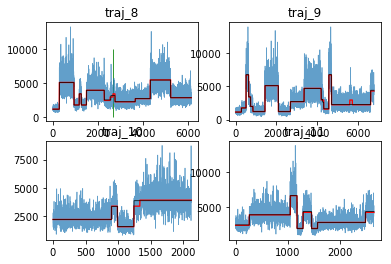

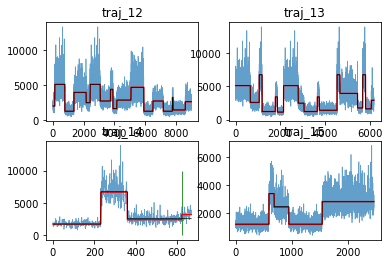

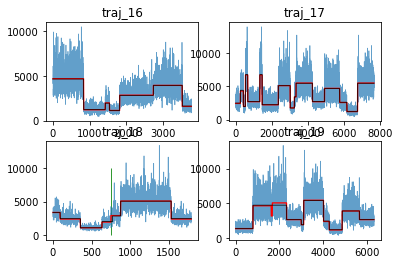

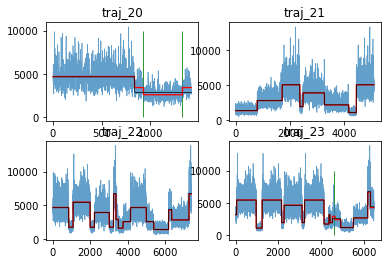

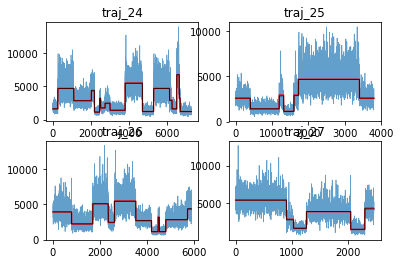

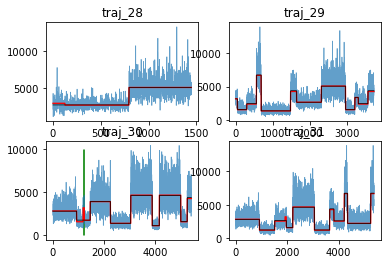

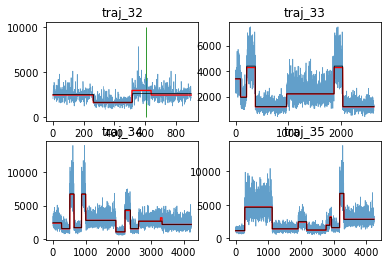

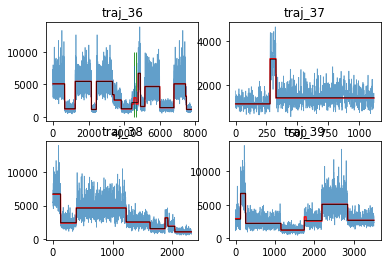

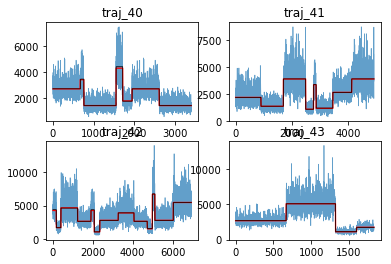

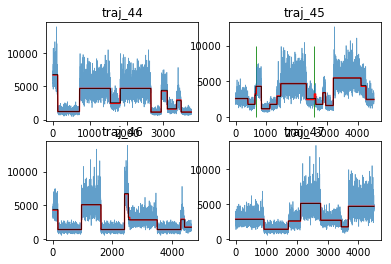

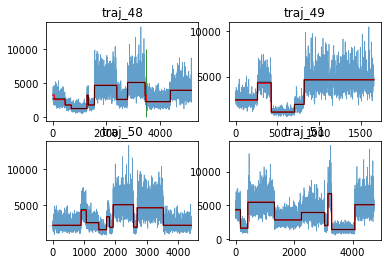

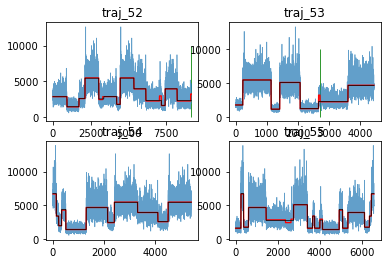

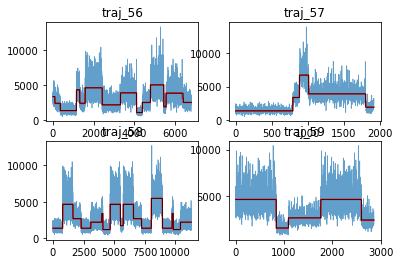

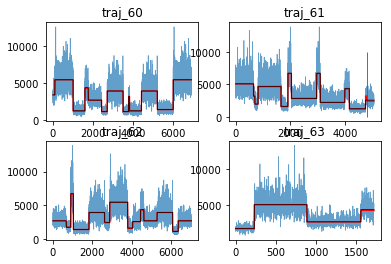

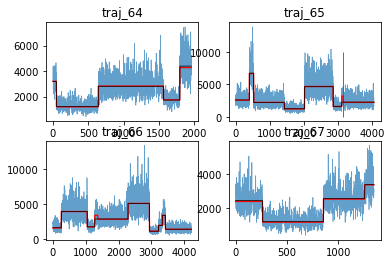

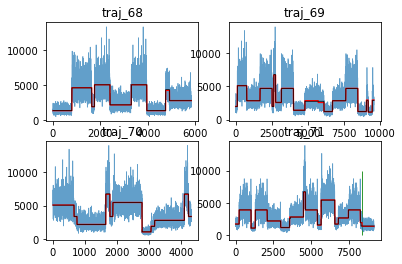

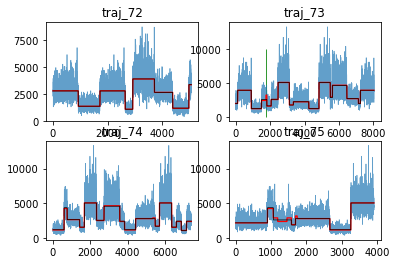

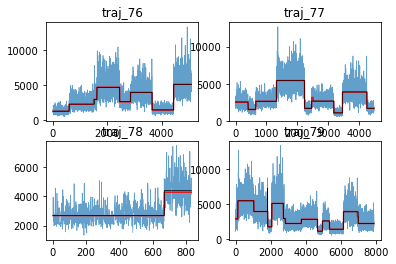

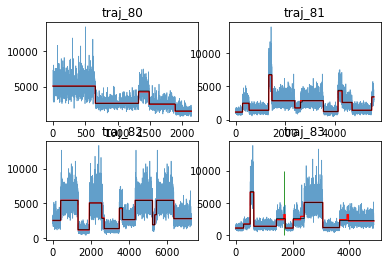

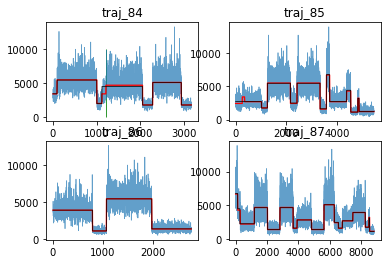

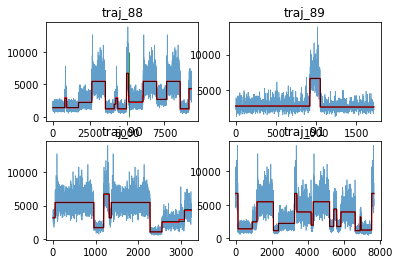

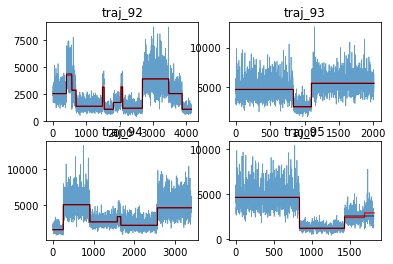

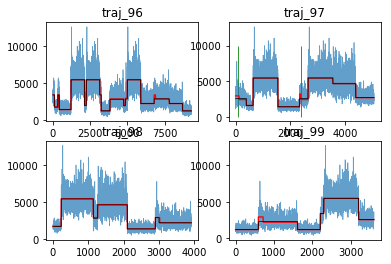

In [24]:
filename = 'test_refinement.pdf'
with PdfPages(filename) as pdf:
    for i in range(25):
        fig = plt.figure()
        for j in range(4):
            ax = fig.add_subplot(2, 2, j+1)
            ax.plot(trajs[i*4+j], linewidth=0.7, alpha=0.7)
            ax.plot(step['traj_{}'.format(i*4+j)], color='red', linewidth=1.3)
            ax.plot(detector.step_function['traj_{}'.format(i*4+j)], color='black', linewidth=0.7)
            ax.vlines(detector.refined_change_points['traj_{}'.format(i*4+j)]['ts'], ymin=0, ymax=10000, color='green', linewidth=0.8)
            plt.title('traj_{}'.format(i*4+j))
        pdf.savefig(bbox_inches='tight')

In [14]:
pickle.dump(detector, open('refinement_detector.pickle', 'wb'))

In [18]:
# Compute confusion matrix
cm = np.zeros((2, 2))
tp = 0
fp = 0
fn = 0
for t in range(len(trajs)):
    true_positive = []
    false_negative = true_ts['traj_{}'.format(t)]
    false_positive = np.asarray(detector.change_points['traj_{}'.format(t)]['ts'].append(
            detector.refined_change_points['traj_{}'.format(t)]['ts']))
    index_neg = []
    for i, t_ts in enumerate(false_negative):
        for j, p_ts in enumerate(false_positive):
            if t_ts-100 <= p_ts <= t_ts+100:
                true_positive.append(p_ts)
                index_neg.append(i)
                false_positive = np.delete(false_positive, j)
                break
    false_negative = np.delete(false_negative, index_neg)
    # sanity check
    assert(len(true_ts['traj_{}'.format(t)]) == (len(true_positive) + len(false_negative)))
    assert(len(np.asarray(detector.change_points['traj_{}'.format(t)]['ts'].append(
                    detector.refined_change_points['traj_{}'.format(t)]['ts']))) == 
           (len(true_positive) + len(false_positive)))
    tp += len(true_positive)
    fp += len(false_positive)
    fn += len(false_negative)
cm = np.array(([tp, fp], [fn, 0]))

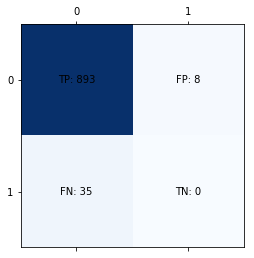

In [19]:
# Plot confusion matrix
key = [['TP', 'FN'], ['FP', 'TN']]
plt.matshow(cm, cmap='Blues')
for (j, k), label in np.ndenumerate(cm):
    l = key[k][j] + ': ' + str(int(label))
    plt.text(k,j,l,ha='center',va='center')

True Positive: 893

False Positive: 8

False Negative: 35

The false negative rate (the amount of true change ponits that are missed) is decreased 42% relative to the false negative rate before refinement. 